In [8]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
from matplotlib.animation import FuncAnimation
from numba import jit
from scipy.spatial.distance import cdist
from sklearn.preprocessing import normalize
%matplotlib inline
from IPython.display import HTML

# box size
L = 60
N = 100
Field_of_perception = 270
interior_angle = 0.5*np.radians(Field_of_perception)
eta = 0.05
dt = 0.1
time_step = 1000
s = 3
turning_rate = np.radians(40)
rr = 1
dro=1.5
dra=12
ro = rr+dro
ra = ro+dra

pos_array = L* np.random.rand(N, 3)
dir_array = np.random.uniform(low=-1, high=1, size=(N, 3))




In [9]:
# MIC periodic distance

def periodic_distance(pos, box_size):
    dif=pos-pos[:,None]
    periodic = np.mod(dif + box_size / 2, box_size) - box_size / 2
    return np.sqrt(np.sum(periodic ** 2,axis=-1))

def angle_between(point1, point2, dir1):
    v1 = dir1
    v2 = (point2 - point1)
    norm1 = np.linalg.norm(v1, axis=-1)
    norm2 = np.linalg.norm(v2, axis=-1)
    zero_mask1 = (norm1 == 0)
    zero_mask2=(norm2 == 0)
    norm1[zero_mask1] = 1
    norm2[zero_mask2] = 1
    cos_angles = np.sum(v1 * v2, axis=-1) / (norm1 * norm2)
    cos_angles = np.clip(cos_angles, -1.0, 1.0)
    return np.arccos(cos_angles)


def periodic(pos_array,L):
    #signs!!!!!!
    diff=pos_array-pos_array[:,np.newaxis,:]
    uper=(diff>L/2)
    lower=(diff<-L/2)
    return np.where(uper, -L,0)+np.where(lower,L,0)

def angle_between_p(point1, point2, dir1,pos_array,L):
    dif_b=periodic(pos_array,L) ###############
    v1 = dir1
    v2 = (point2 - point1) +dif_b
    norm1 = np.linalg.norm(v1, axis=-1)
    norm2 = np.linalg.norm(v2, axis=-1)
    zero_mask1 = (norm1 == 0)
    zero_mask2 = (norm2 == 0)
    norm1[zero_mask1] = 1
    norm2[zero_mask2] = 1
    cos_angles = np.sum(v1 * v2, axis=-1) / (norm1 * norm2)
    cos_angles = np.clip(cos_angles, -1.0, 1.0)
    return np.arccos(cos_angles)

def field_of_perception(pos_array, dir_array, interior_angle,L):
    angles = angle_between_p(pos_array[:, None], pos_array[None, :],np.reshape(np.tile(dir_array[:, None], (1, 1, N)), (N, N, 3)),pos_array,L )

    mask = (angles <= interior_angle)
    mask[np.isnan(angles)] = False
    return mask

def tendency(pos_matrix, pos_array,mask,L):
    dif_b = periodic(pos_array,L)###############
    dif = (pos_matrix - pos_array.reshape(N, 1, 3))+dif_b
    dif*=mask[:, :, np.newaxis]

    squared_dir_matrix = dif ** 2
    squared_sum = squared_dir_matrix.sum(axis=-1)
    norm_v = np.zeros_like(dif)

    nonzero_mask = squared_sum != 0
    norm_v[nonzero_mask] = dif[nonzero_mask] / np.sqrt(squared_sum[nonzero_mask])[:, np.newaxis]

    norm_v[np.isnan(norm_v)] = 0
    norm_v *= mask[:, :, np.newaxis]
    dr = np.sum(norm_v, axis=1)
    return normalize(dr, axis=1, norm='l2')


def align(dir_matrix,mask,pos_array,L):
    squared_dir_matrix = dir_matrix ** 2
    squared_sum = squared_dir_matrix.sum(axis=-1)
    norm_v = np.zeros_like(dir_matrix)

    nonzero_mask = squared_sum != 0
    norm_v[nonzero_mask] = dir_matrix[nonzero_mask] / np.sqrt(squared_sum[nonzero_mask])[:, np.newaxis]

    norm_v[np.isnan(norm_v)] = 0
    norm_v*=mask[:, :, np.newaxis]
    dr=np.sum(norm_v, axis=1)
    return normalize(dr, axis=1, norm='l2')

def neighbor(pos_array, radius_down, radius_up):
    dist = periodic_distance(pos_array,L)
    neighbors = np.logical_and(radius_down < dist, dist < radius_up)
    return neighbors

def rotate_vector(v1, v2, theta):

    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)
    axis = np.cross(v1, v2)
    angle = theta
    rot_matrix = np.array([[np.cos(angle) + axis[0] ** 2 * (1 - np.cos(angle)),
                            axis[0] * axis[1] * (1 - np.cos(angle)) - axis[2] * np.sin(angle),
                            axis[0] * axis[2] * (1 - np.cos(angle)) + axis[1] * np.sin(angle)],
                           [axis[1] * axis[0] * (1 - np.cos(angle)) + axis[2] * np.sin(angle),
                            np.cos(angle) + axis[1] ** 2 * (1 - np.cos(angle)),
                            axis[1] * axis[2] * (1 - np.cos(angle)) - axis[0] * np.sin(angle)],
                           [axis[2] * axis[0] * (1 - np.cos(angle)) - axis[1] * np.sin(angle),
                            axis[2] * axis[1] * (1 - np.cos(angle)) + axis[0] * np.sin(angle),
                            np.cos(angle) + axis[2] ** 2 * (1 - np.cos(angle))]])
    v = np.squeeze(normalize([rot_matrix.dot(v1)],'l2'))

    return v


def turning(new_dir_array, dir_array, turning_rate):
    angles=angle_between(np.zeros((N,3)), dir_array, new_dir_array)
    mask=angles<turning_rate * dt
    indexs=np.squeeze(np.argwhere(mask == False))
    for i in indexs:
        new_dir_array[i] = rotate_vector(dir_array[i], new_dir_array[i], turning_rate * dt)
    # for i in range(len(new_dir_array)):
    #     a = angle(new_dir_array[i], dir_array[i])
    #     if np.abs(a) > turning_rate * dt:
    #         new_dir_array[i] = rotate_vector(dir_array[i],new_dir_array[i],  turning_rate * dt)
    # for i in range(len(new_dir_array)):
    #     a = angle(new_dir_array[i], dir_array[i])
    #     if np.abs(a) > turning_rate * dt:
    #         new_dir_array[i] = rotate_vector(dir_array[i],new_dir_array[i],  turning_rate * dt)

    return new_dir_array


def update(pos_array, dir_array, rr, ro, ra, turning_rate,L):
    filed = field_of_perception(pos_array, dir_array, interior_angle,L)
    neighr, neigho, neigha, neigh = neighbor(pos_array, 0, rr), \
                                    neighbor(pos_array, rr, ro ) * filed, \
                                    neighbor(pos_array,ro ,ra)* filed, \
                                    neighbor(pos_array, 0, ra)* filed

    in_r = (np.sum(neighr, axis=1) > 0)
    in_o = (np.sum(neigho, axis=1) > 0)
    in_a = (np.sum(neigha, axis=1) > 0)
    around = (np.sum(neigh, axis=1) > 0)

    pos_matrix = np.tile(pos_array, (N, 1)).reshape(N, N, 3)
    dir_matix=np.tile(dir_array, (N, 1)).reshape(N, N, 3)
    dr = -1*tendency(pos_matrix , pos_array,neighr,L)
    do = align(dir_matix,neigho,pos_array,L)
    da = tendency(pos_matrix , pos_array,neigha,L)

    in_o_not_r = in_o * ~in_r
    in_a_not_r = in_a * ~in_r

    in_o_and_a = in_o_not_r * in_a_not_r

    just_in_o = in_o_not_r * ~in_o_and_a
    just_in_a = in_a_not_r * ~in_o_and_a
    new_dir = dr * in_r[:, np.newaxis] + do * just_in_o[:, np.newaxis] + da * just_in_a[:, np.newaxis] + 0.5 * (
            do + da) * in_o_and_a[:, np.newaxis] + dir_array * ~around[:, np.newaxis]
    new_dir=new_dir / np.sqrt((new_dir ** 2).sum(axis=-1))[:, np.newaxis]
    err = np.random.normal(loc=0, scale=eta, size=(N, 3))
    new_dir += err
    update_dir = turning(new_dir, dir_array, turning_rate)
    return normalize(update_dir, axis=1)

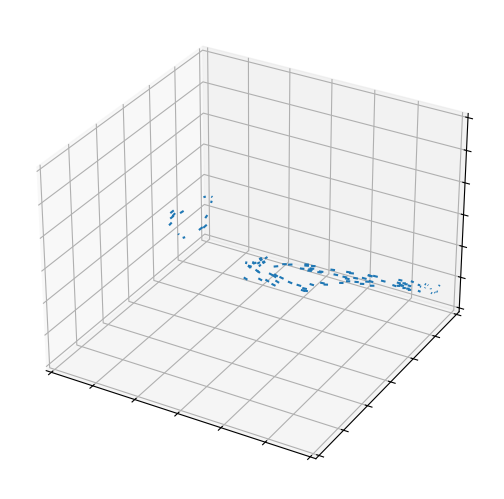

In [10]:
fig = plt.figure()
ax = p3.Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

ax.set_zlim3d(bottom=0, top=L)
ax.set_xlim3d(left=0, right=L)
ax.set_ylim3d(bottom=0, top=L)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

quiver = ax.quiver(pos_array[:, 0], pos_array[:, 1], pos_array[:, 2], dir_array[:, 0], dir_array[:, 1], dir_array[:, 2],
                   length=0.5, normalize=True, arrow_length_ratio=0.5)


def update_quiver(t):
    global pos_array, dir_array, quiver
    dir_array= update(pos_array, dir_array, rr, ro, ra, turning_rate,L)
    vel_array = s * dir_array
    pos_array += vel_array * dt
    pos_array = np.mod(pos_array, L)
    quiver.set_offsets(pos_array)
    new_seg = np.concatenate((pos_array[:, np.newaxis, :], pos_array[:, np.newaxis, :] + dir_array[:, np.newaxis, :]),
                             axis=1).reshape(N, 2, 3)
    quiver.set_segments(new_seg)
    return quiver


ani = FuncAnimation(fig, update_quiver, frames=time_step, interval=10)
HTML(ani.to_html5_video())